[参考](https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf)

In [2]:
import tensorflow
from tensorflow.keras import  models, layers
import numpy as np
import matplotlib.pyplot as plt

# データ生成

## sin波

In [3]:
# sin波を生成
def generate_sin(dt=0.01, sample_size=100):
    """
    0からdtずつdt*(sample_size)
    """
    return np.sin(2.*np.pi*np.linspace(0, dt*(sample_size-1), sample_size))

# 正規分布N(0, std)に従うノイズを加える
def noised_series(series, std=0.1):
    return series + np.random.normal(loc=0, scale=std, size=len(series))


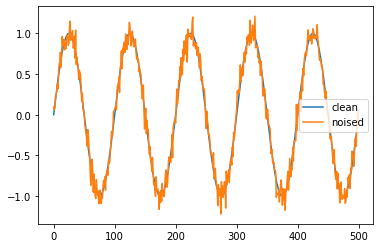

In [4]:
clean_sin = generate_sin(sample_size=500)
noised_sin = noised_series(clean_sin)

plt.plot(clean_sin, label='clean')
plt.plot(noised_sin, label='noised')
plt.legend()

## test, train split

In [5]:
# test, train split
train_ratio = 0.7
train_size = int(len(noised_sin)*train_ratio)
train = noised_sin[:train_size]
test = noised_sin[train_size:]

print(f'train_size: {train_size}')

train_size: 350


## RNN用feature, targetに変換

In [6]:
# RNN用feature, targetを生成 in: raw_data, delay out: feature, targets
def convert_data_for_RNN(raw_data, delay=25):
    """
    targetに対してdelay個の過去データをfeatureとする
    """
    features = np.array([raw_data[n:n+delay] for n in range(len(raw_data)-delay)]).reshape(-1, 25,1)
    targets = raw_data[delay:].reshape(-1,1,1)
    return features, targets

In [7]:
train_features, train_targets = convert_data_for_RNN(train)
test_features, test_targets = convert_data_for_RNN(test)
train_features.shape, train_targets.shape

((325, 25, 1), (325, 1, 1))

# モデル作成

In [8]:
# モデル構築
"""
n_hidden: 
dropout, recurrent_dropout
regulalizer
deep化
"""

delay = 25 # 時間遅れstep
out_size = 1 # targetのsize
n_hidden = 500 # 中間層のノード数

model = models.Sequential(name='RNN')
model.add(layers.SimpleRNN(n_hidden, input_shape=(delay, out_size), return_sequences=False, dropout=0, recurrent_dropout=0,))
model.add(layers.Dense(out_size))
# model.add(layers.Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='Adam')
model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 500)               251000    
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 251,501
Trainable params: 251,501
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 学習
# callbacks.EarlyStopping()
model.fit(train_features,
          train_targets,
          batch_size=20,
          epochs=10,
          validation_split=0.3,
        #   callbacks=[callbacks.EarlyStopping(min_delta=1e-10)]
          )

Epoch 1/10
12/12 [==============================] - 1s 29ms/step - loss: 1.4345 - val_loss: 0.0394
Epoch 2/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0546 - val_loss: 0.0471
Epoch 3/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0292 - val_loss: 0.0173
Epoch 4/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0178 - val_loss: 0.0149
Epoch 5/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0147 - val_loss: 0.0125
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.0172
Epoch 7/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0156
Epoch 8/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 9/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 10/10
12/12 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0173


11/11 [==============================] - 0s 4ms/step - loss: 0.0160


0.015997938811779022

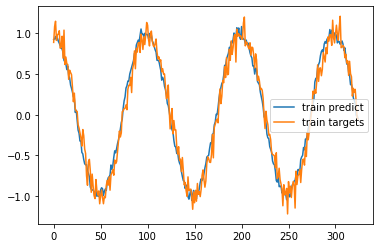

In [10]:
# fittingの確認
train_predict = model.predict(train_features)

plt.plot(train_predict, label='train predict')
plt.plot(train_targets[:, 0,0], label='train targets')
plt.legend()

model.evaluate(train_features, train_targets)

4/4 [==============================] - 0s 4ms/step - loss: 0.0169


0.016931170597672462

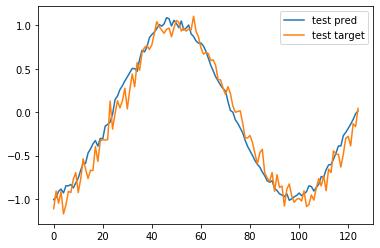

In [11]:
# 未来の予測
test_predict = model.predict(test_features)

plt.plot(test_predict, label='test pred')
plt.plot(test_targets[:,0,0], label='test target')
plt.legend()

model.evaluate(test_features, test_targets)

In [12]:
np.sqrt(0.017138570547103882)

0.1309143634102228